In [190]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
from pmdarima import auto_arima, model_selection, ARIMA
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta, date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import joblib

In [213]:
%run datatools.py

# Read endogenous and exogenous data and filter country/dates

In [192]:
# We filter the country, the variable to predict and the dates

country = 'Spain'
variable = 'new_cases_'
col = variable + country
datecol = 'date'
initialdate = '2020-01-01'   # first day of the year, where most of our data starts
# moving intialdate by 6, since we later apply 7-day rolling mean to our data:
initialdateshift = str(date.fromordinal(datetime.strptime(initialdate, '%Y-%m-%d').toordinal() + 6)) 
enddate = str(date.fromordinal(date.today().toordinal()-1))   # yesterday's date: last day of available data

In [193]:
# We read the endogenous data (coronavirus data) (for now, from a local file)

covid_ctry_varR = pd.read_csv('./data/endogenous.csv', parse_dates=[datecol], index_col=[datecol], usecols=[datecol, col])

In [194]:
# We now read the exogenous data (for now, from a local file):

exogenous = pd.read_csv('./data/exogenous.csv', parse_dates=[datecol], index_col=[datecol])

# We now need to filter the country:
exogenous_ctryR = exogenous.loc[:, exogenous.columns.str.contains(country)]

In [195]:
# We check that effectively endogenous and exogenous data have the same length:
print(len(covid_ctry_varR) == len(exogenous_ctryR))

True


# Visualize endogenous and exogenous data and normalize it all

(239, 1) (239, 14)


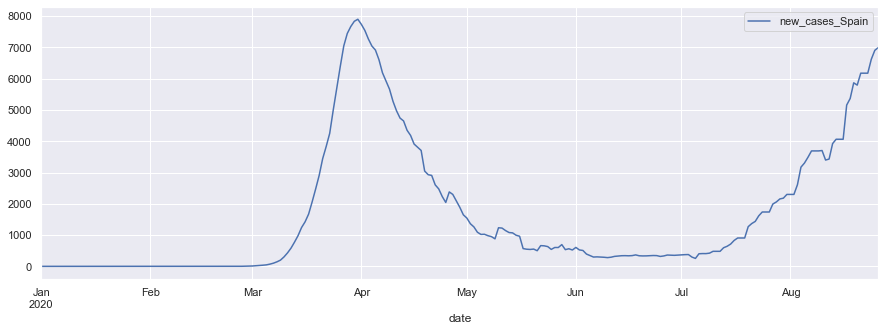

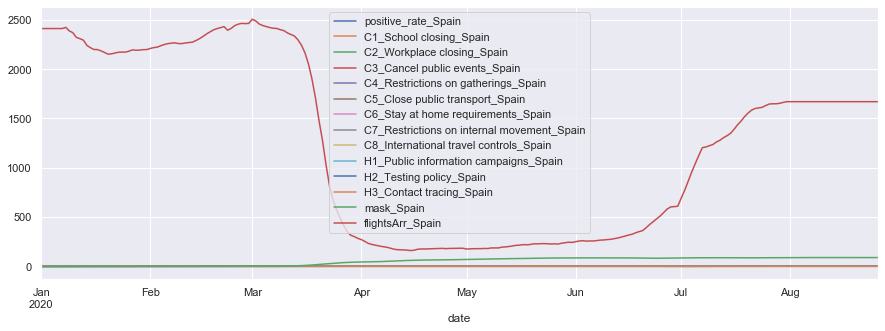

In [196]:
print(covid_ctry_varR.shape, exogenous_ctryR.shape)
covid_ctry_varR.plot()
exogenous_ctryR.plot()

In [197]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(exogenous_ctryR)
scaled_input = pd.DataFrame(scaled_input, index=exogenous_ctryR.index, columns=exogenous_ctryR.columns)
X = scaled_input

In [198]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR)
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.columns[0])
y = scaled_output.resample('1D').sum()

(239,) (239, 14)


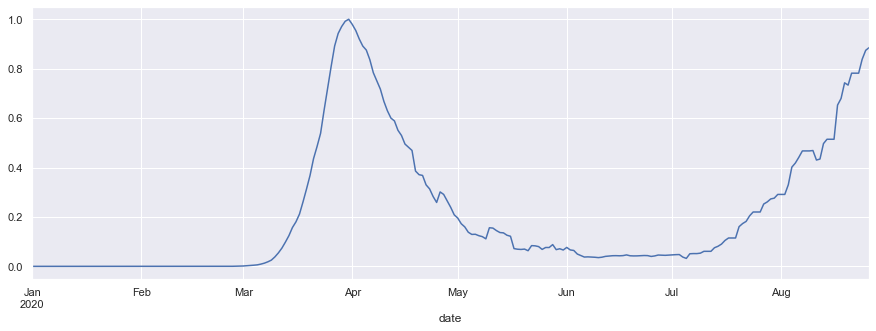

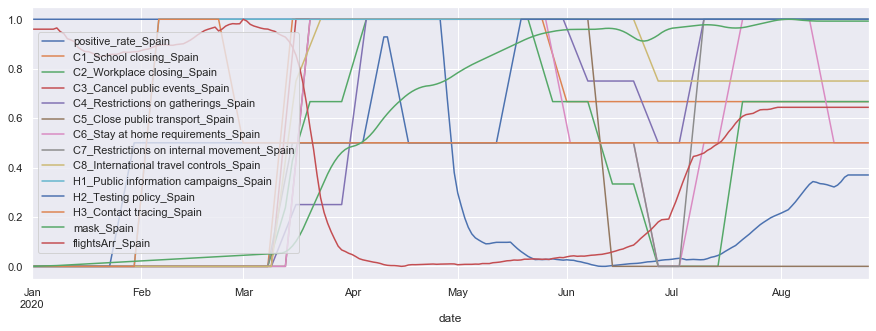

In [199]:
print(y.shape, X.shape)
y.plot()
X.plot()

# Split endogenous and exogenous data into train/test

In [200]:
# We are going to use 85% for training, since most of the series is the big curve, 
# and then we have the smaller changes in coronavirus cases towards the end
train_size = int(len(covid_ctry_varR) * 0.85)
test_size = len(covid_ctry_varR) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [201]:
train_size, test_size

(203, 36)

# Stationarity: estimate differencing term (d)

In [202]:
# Performing different tests to estimate best value of 'd'

## Adf Test
d_adf = ndiffs(y_train, test='adf')
print('ADF test: ', d_adf)

# KPSS test
d_kpss = ndiffs(y_train, test='kpss')
print('KPSS test: ', d_kpss)

# PP test:
d_pp = ndiffs(y_train, test='pp')
print('PP test: ', d_pp)

ADF test:  2
KPSS test:  1
PP test:  1


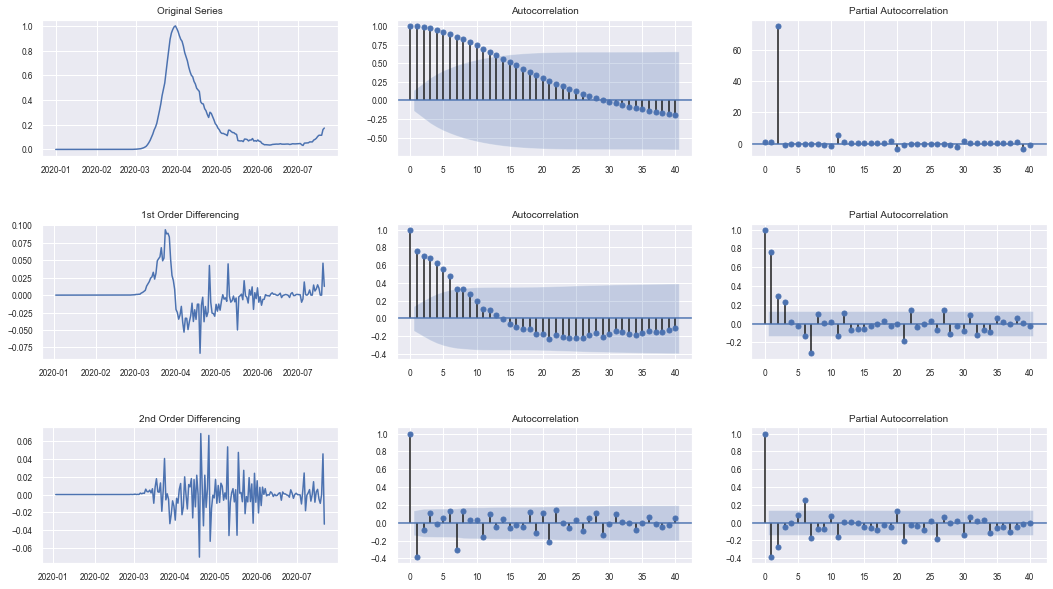

In [203]:
# Plotting ACF and PACF for different 'd' values (d=1, d=2):

plot_acf_pacf(y_train)
sns.reset_defaults
plt.rcParams["figure.figsize"] = (15, 5)

**Consider if d=1 would be best, since the ACF/PACF for d=2 turns largely negative at lag 1, which is an indication that the series may be over-differenced**

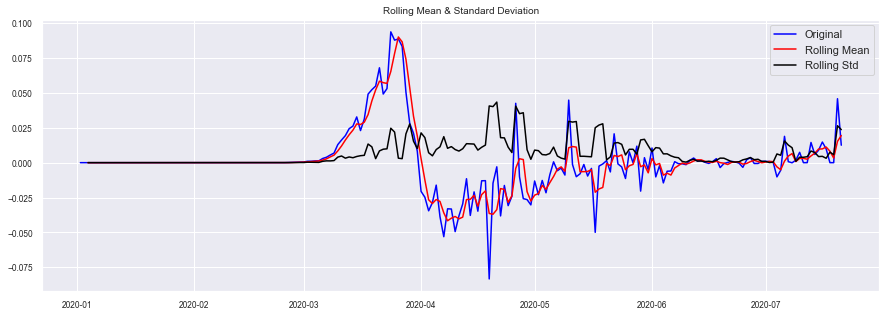

Result of Dicky-Fuller Test


Test Statistic           -3.298244
p-value                   0.014957
#Lags Used                7.000000
#Observations Used      194.000000
Critical Value (1%)      -3.464515
Critical Value (5%)      -2.876556
Critical Value (10%)     -2.574775
dtype: float64

In [204]:
# Test stationarity and print results of ADF test:
test_stationarity(y_train.diff().dropna())

# Estimate orders p and q of ARIMA model, using auto_arima

In [205]:
# Perform different auto_arima searches and sort results by lowest AIC:
result_table = autoarimas(y_train, X_train)
result_table

,parameters,aic
0,"(0, 2, 3)",-1151.756378
1,"(0, 2, 1)",-1143.463018
2,"(1, 1, 3)",-1142.912673
3,"(1, 1, 1)",-1134.142570


# Perform cross-validation on top 2 models and select the best. Then train and fit SARIMAX model with the one that gave best results

In [206]:
# Extract top 2 models from previous step (first 2 elements, since they are sorted):
model1 = ARIMA(order=result_table.iloc[0,0])
model2 = ARIMA(order=result_table.iloc[1,0])

In [207]:
best_order = cross_val(y_train, X_train, model1, model2)

Model 1 CV scores: ['83.6996', '162.5143', '101.0036', '135.9578', '176.5469', '185.0878', '97.2850', '138.4538', '128.5841']
Model 2 CV scores: ['78.3616', '165.0059', '76.0203', '140.6708', '173.8388', '182.5234', '91.6943', '175.7422', '115.8839']
Lowest average SMAPE: 133.30457693939147 (model2)
Best model order: (0, 2, 1)


                               SARIMAX Results                                
Dep. Variable:        new_cases_Spain   No. Observations:                  203
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 588.772
Date:                Thu, 27 Aug 2020   AIC                          -1145.544
Time:                        18:19:18   BIC                          -1092.691
Sample:                    01-01-2020   HQIC                         -1124.158
                         - 07-21-2020                                         
Covariance Type:                  opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
positive_rate_Spain                            0.2018      0.070      2.894      0.004       0.065       0.338
C1_School closing_Spain            

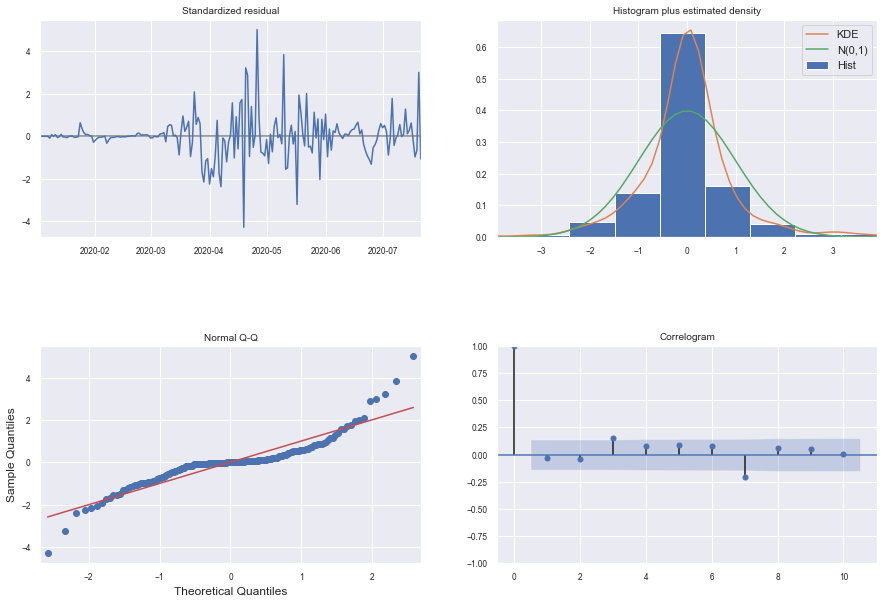

In [208]:
best_model = sm.tsa.statespace.SARIMAX(y_train, order=best_order, exog=X_train)
results = best_model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(15,10));

# Perform/plot in-sample prediction and out-of-sample forecast and evaluate model MAE

In [209]:
train_size, test_size, X_test.shape

(203, 36, (36, 14))

Test MAE: 0.069


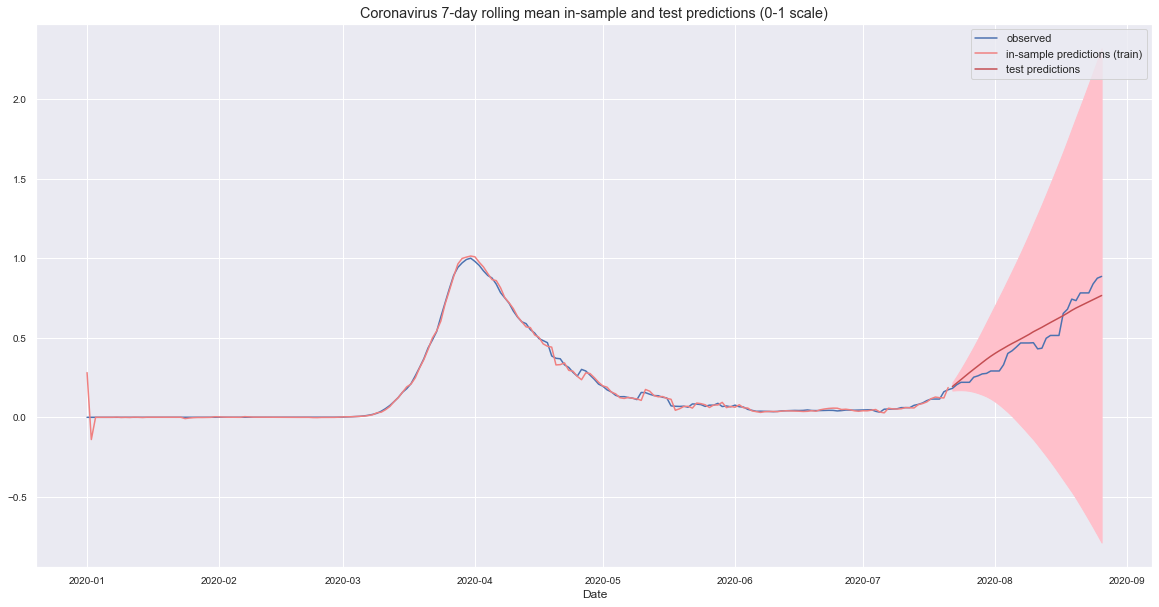

In [214]:
in_predictions, mean_forecast = in_out_fcast_plot(results, test_size, y, y_test, X_train, X_test)

# set title and show plot
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (0-1 scale)')
plt.show()

# Scale data back to original values and plot

In [215]:
trainPredict = sc_out.inverse_transform(in_predictions.values.reshape(-1,1))
trainPredictS = pd.Series(trainPredict.flatten(), index=covid_ctry_varR[:train_size].index, name=covid_ctry_varR.columns[0])

In [216]:
testPredict = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
testPredictS = pd.Series(testPredict.flatten(), index=covid_ctry_varR[train_size:].index, name=covid_ctry_varR.columns[0])

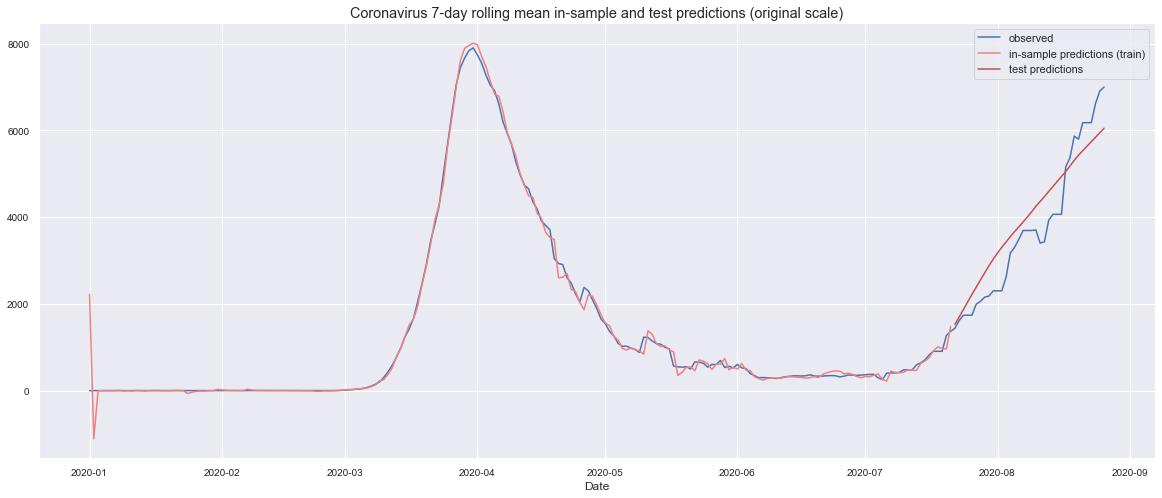

In [217]:
# plot the data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(trainPredictS.index, trainPredictS, color='lightcoral', label='in-sample predictions (train)')

plt.plot(testPredictS.index, testPredictS, color='r', label='test predictions')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (original scale)')
plt.rcParams["figure.figsize"] = (20, 8)
plt.legend()
plt.show()

In [218]:
print("Test MAE (original scale): %.3f" % np.sqrt(mean_absolute_error(covid_ctry_varR[train_size:], testPredictS)))

Test MAE (original scale): 23.361


# Save model so we can then update with future values

In [219]:
# Set model name
filename = './models/' + country + 'SARIMAXmodel.pkl'

# Pickle it
joblib.dump(results, filename)

['./models/SpainSARIMAXmodel.pkl']

In [220]:
# Load the model back in
loaded_model = joblib.load(filename)

In [221]:
loaded_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        new_cases_Spain   No. Observations:                  203
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 588.772
Date:                Thu, 27 Aug 2020   AIC                          -1145.544
Time:                        18:23:56   BIC                          -1092.691
Sample:                    01-01-2020   HQIC                         -1124.158
                         - 07-21-2020                                         
Covariance Type:                  opg                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
positive_rate_Spain                            0.2018      0.070      2.894      0.004       0.065       0.338
C1_School closing_Spain                        0.0090      0.099      0.091      0.927      -0.184       0.202
C2_Workplace closing_Spain                     0.0329      0.086      0.381      0.703      -0.136       0.202
C3_Cancel public events_Spain                  0.1839      0.245      0.752      0.452      -0.296       0.663
C4_Restrictions on gatherings_Spain           -0.0202      0.070     -0.290      0.772      -0.157       0.116
C5_Close public transport_Spain               -0.0213      0.146     -0.146      0.884      -0.307       0.264
C6_Stay at home requirements_Spain            -0.0325      0.132     -0.246      0.806      -0.292       0.227
C7_Restrictions on internal movement_Spain     0.0483      0.103      0.469      0.639      -0.154       0.250
C8_International travel controls_Spain        -0.2550      0.299     -0.854      0.393      -0.840       0.330
H1_Public information campaigns_Spain         -0.0712      1.076     -0.066      0.947      -2.180       2.038
H2_Testing policy_Spain                       -0.1145      0.056     -2.040      0.041      -0.224      -0.004
H3_Contact tracing_Spain                       0.0407      1.057      0.038      0.969      -2.031       2.112
mask_Spain                                     1.8586      0.432      4.303      0.000       1.012       2.705
flightsArr_Spain                               0.0824      0.244      0.338      0.735      -0.396       0.561
ma.L1                                         -0.5403      0.044    -12.366      0.000      -0.626      -0.455
sigma2                                         0.0002   8.94e-06     18.637      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       72.83   Jarque-Bera (JB):               317.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              51.34   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Update model with test observations, to get it ready for future forecasts

In [222]:
# Update model with test sample and re-fit parameters:
res_updated = results.append(y_test, exog=X_test, refit=True)

                               SARIMAX Results                                
Dep. Variable:        new_cases_Spain   No. Observations:                  239
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 620.038
Date:                Thu, 27 Aug 2020   AIC                          -1208.076
Time:                        18:24:03   BIC                          -1152.587
Sample:                    01-01-2020   HQIC                         -1185.711
                         - 08-26-2020                                         
Covariance Type:                  opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
positive_rate_Spain                            0.1932      0.091      2.119      0.034       0.014       0.372
C1_School closing_Spain            

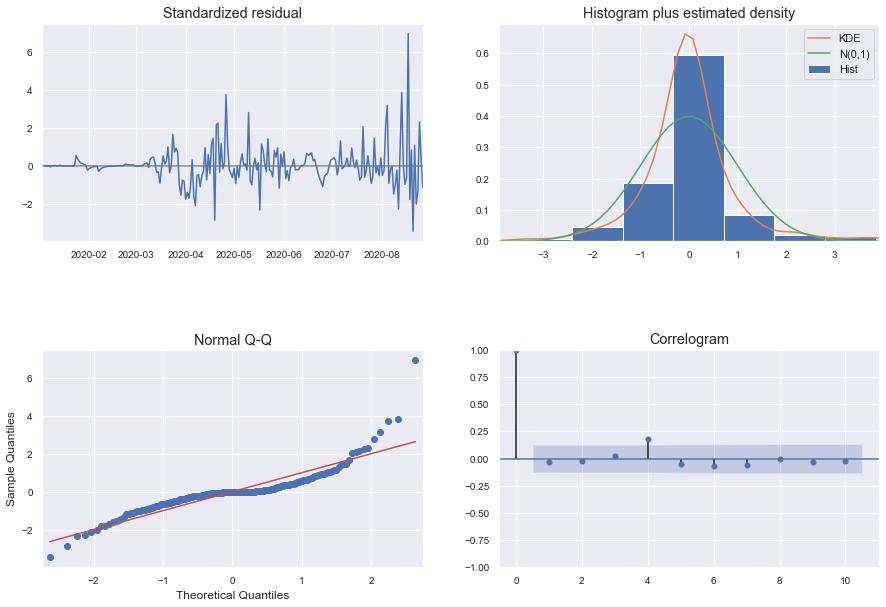

In [223]:
# Print summary of updated model and plot diagnostics, to confirm everything working as expected:
print(res_updated.summary())
res_updated.plot_diagnostics(figsize=(15,10));

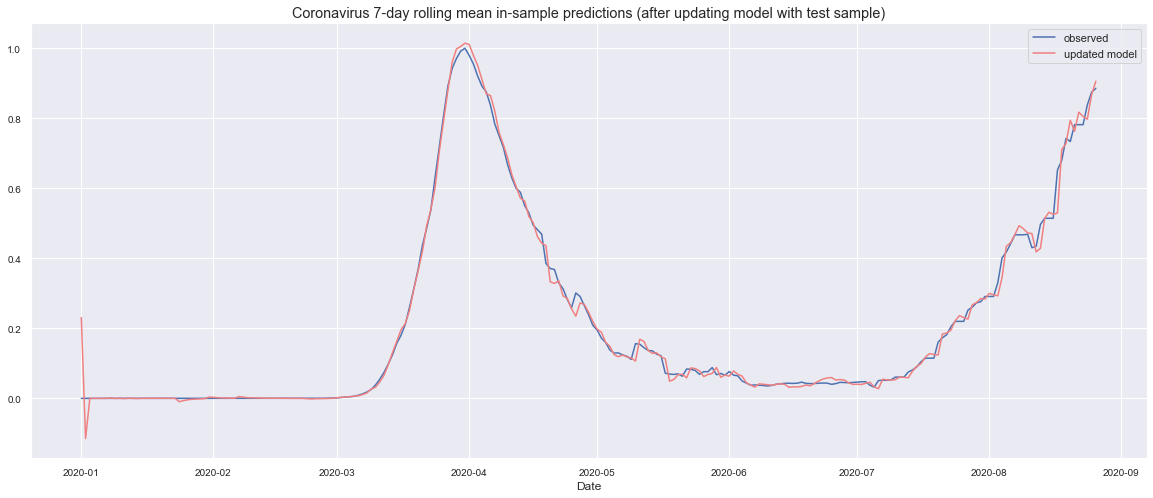

In [224]:
# Plot the updated data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train+test)
plt.plot(res_updated.fittedvalues.index, res_updated.fittedvalues, color='lightcoral', label= 'updated model')
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample predictions (after updating model with test sample)')
plt.legend()
plt.show()

In [225]:
# Save model again, after updating it with test sample:

joblib.dump(res_updated, filename)

['./models/SpainSARIMAXmodel.pkl']

# Perform forecast

In [226]:
forecastdays = 14
new_begin = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + 1))
new_date = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + forecastdays))
new_index = pd.date_range(initialdateshift, new_date, freq='D')
exog_conc = exogenous_ctryR.reindex(new_index).interpolate()

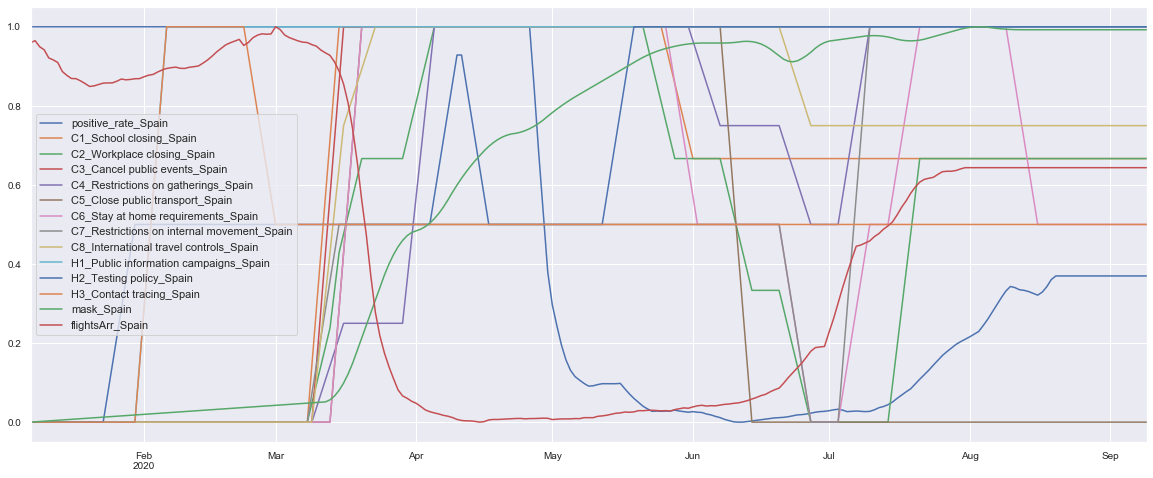

In [227]:
# Re-scale exogenous date with new added days:
sc_in_fc = MinMaxScaler(feature_range=(0, 1))
scaled_input_fc = sc_in_fc.fit_transform(exog_conc)
scaled_input_fc = pd.DataFrame(scaled_input_fc, index=exog_conc.index, columns=exog_conc.columns)
X_fc = scaled_input_fc
X_fc.plot()

[0.91026668 0.93503963 0.95981259 0.98458555 1.0093585  1.03413146
 1.05890442 1.08367737 1.10845033 1.13322328 1.15799624 1.1827692
 1.20754215 1.23231511]


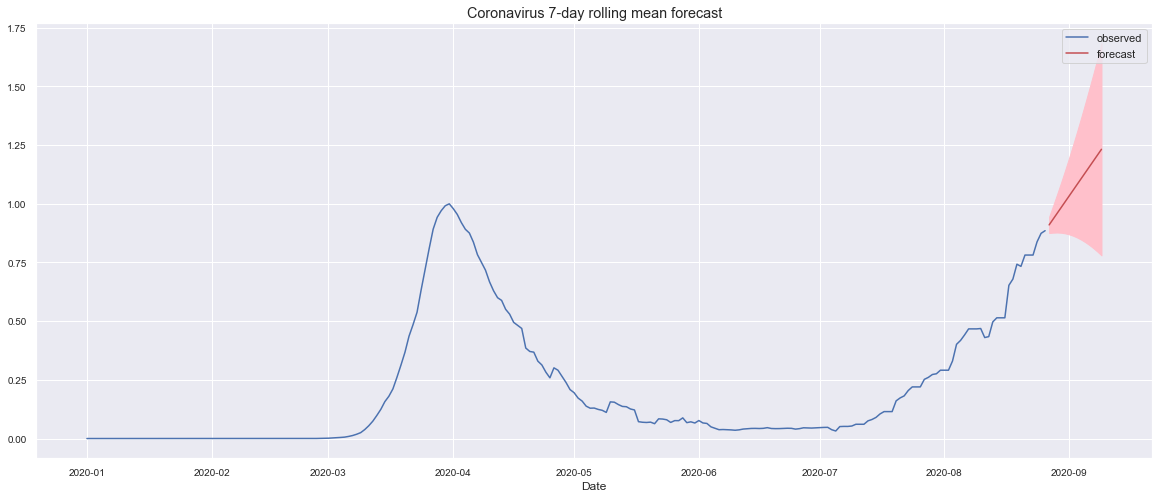

In [228]:
# Generate out of sample forecast

forecast = res_updated.get_forecast(steps=forecastdays, exog=X_fc[new_begin:new_date])

# Extract prediction mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower ' + y.name]
upper_limits = confidence_intervals.loc[:,'upper ' + y.name]

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(y.index, y, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast')
plt.legend()
plt.show()

In [229]:
forecast14 = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
forecast14S = pd.Series(forecast14.flatten(), index=mean_forecast.index, name='new_cases_forecast')

forecast14_ll = sc_out.inverse_transform(lower_limits.values.reshape(-1,1))
forecast14_llS = pd.Series(forecast14_ll.flatten(), index=lower_limits.index, name='new_cases_forecast_ll')

forecast14_ul = sc_out.inverse_transform(upper_limits.values.reshape(-1,1))
forecast14_ulS = pd.Series(forecast14_ul.flatten(), index=upper_limits.index, name='new_cases_forecast_ul')

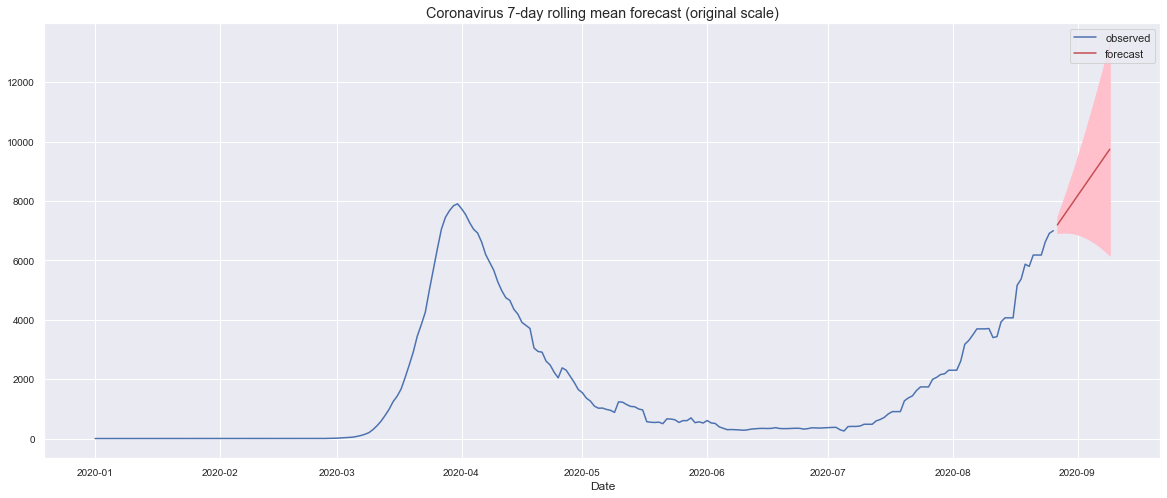

In [230]:
# plot the data
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(forecast14S.index, forecast14S, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(forecast14_llS.index, forecast14_llS, forecast14_ulS, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast (original scale)')
plt.legend()
plt.show()

In [231]:
# Print forecasted values:

forecast14S_l = ["%.1f" % elem for elem in forecast14S]
print(forecast14S_l)

['7192.9', '7388.7', '7584.4', '7780.2', '7976.0', '8171.7', '8367.5', '8563.2', '8759.0', '8954.7', '9150.5', '9346.2', '9542.0', '9737.8']


In [ ]:
sm.__version__

In [ ]:
import pmdarima as pm
pm.__version__